In [10]:
import pandas as pd
import numpy as np
from glob import glob
from re import match, sub
from missingno import matrix as mmatrix
from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from math import ceil
from datetime import datetime, timedelta
from scipy.stats import pearsonr
from statsmodels.formula.api import ols
from os import listdir

from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
# from tensorflow import keras # for building Neural Networks
# from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, MAPE, MeanAbsolutePercentageError, MSE
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed, LSTM # for creating layers inside the Neural Network
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler


In [2]:
%%html
<style>
    .jp-WindowedPanel-outer {
        padding: 0% 10% !important;
    }
    .jp-RenderedImage img {
        width: 50%;
        transform: translateX(-75%);
        margin-left: 50%;
    }
</style>


In [3]:
df = pd.read_csv('data/modelling_data.csv', parse_dates=['DATETIME'], date_format='%Y-%m-%d %H:%M:%S')

y_cols = ['h1_ahead', 'h24_ahead']
df = df[['DATETIME', 'TOTALDEMAND', *y_cols]].copy()

for i in range(1, 49):
    shift = 30*i
    df_shift = df.copy()[['DATETIME', 'TOTALDEMAND']].rename(columns={'TOTALDEMAND': f'TM{shift}'})
    df_shift['DATETIME'] += timedelta(minutes=shift)
    df = pd.merge(df, df_shift, how='left', on='DATETIME')

df = df.set_index('DATETIME').dropna()

X_df, y_df = df.drop(columns=y_cols), df[y_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_df)

X_y = [X_train, X_test, y_train, y_test] = train_test_split(
    X_scaled, y_df, test_size=0.2, shuffle=False
)
X_y = [tf.convert_to_tensor(d) for d in X_y]
[X_train, X_test, y_train, y_test] = X_y

train_val_I = TimeSeriesSplit(n_splits=10).split(X_train)

for train, val in train_val_I:
    print(train.shape, val.shape)

X_val = X_train[train.max()+1:]
y_val = y_train[train.max()+1:]
X_train = X_train[:train.max()+1]
y_train = y_train[:train.max()+1]

X_train


(13364,) (13356,)
(26720,) (13356,)
(40076,) (13356,)
(53432,) (13356,)
(66788,) (13356,)
(80144,) (13356,)
(93500,) (13356,)
(106856,) (13356,)
(120212,) (13356,)
(133568,) (13356,)


<tf.Tensor: shape=(133568, 49), dtype=float64, numpy=
array([[-0.38975106, -0.22813714, -0.0266089 , ..., -0.4613315 ,
        -0.20795177, -0.03000403],
       [-0.5699047 , -0.38984025, -0.22819869, ..., -0.74660287,
        -0.46145011, -0.20804999],
       [-0.75941031, -0.56999883, -0.38990468, ..., -0.98418629,
        -0.74674278, -0.46156052],
       ...,
       [-1.42964722, -1.2212851 , -0.98641875, ..., -1.5736454 ,
        -1.50921521, -1.39359829],
       [-1.51416499, -1.42976487, -1.22136434, ..., -1.53536894,
        -1.57384709, -1.50937604],
       [-1.57052574, -1.51428495, -1.42984782, ..., -1.43311154,
        -1.53556776, -1.57401103]])>

In [6]:
main_input = Input(shape=tuple(X_train[0].shape), name="input")
previous_layer = main_input
for i in range(5):
    # previous_layer = BatchNormalization()(previous_layer)
    previous_layer = Dense(32, name=f"linear_{i+1}", activation='linear')(previous_layer)
    previous_layer = Dense(32, name=f"relu_{i+1}", activation='relu')(previous_layer)
main_output = Dense(2, name=f"output", activation='linear')(previous_layer)

model_mlp = Model(inputs=main_input, outputs=main_output, name="MLP")

def scheduler(epoch, lr):
    return 0.0001 if epoch % 2 == 1 else 0.001

model_mlp.compile(optimizer=Adam(
    learning_rate=.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=1e-4,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanAbsolutePercentageError(), metrics=[MSE])
mlp_history = model_mlp.fit(
    X_train, y_train, verbose=1, validation_data=(X_val, y_val), shuffle=False,
    epochs=300, batch_size=2**10, 
    callbacks=[
        LearningRateScheduler(scheduler), 
        # EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), 
    ]
)



Epoch 1/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 84.9508 - mean_squared_error: 60261164.0000 - val_loss: 27.0543 - val_mean_squared_error: 7946559.5000 - learning_rate: 0.0010
Epoch 2/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19.5848 - mean_squared_error: 4562095.0000 - val_loss: 24.3781 - val_mean_squared_error: 7268135.5000 - learning_rate: 1.0000e-04
Epoch 3/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20.3213 - mean_squared_error: 5058212.5000 - val_loss: 18.4451 - val_mean_squared_error: 4226193.0000 - learning_rate: 0.0010
Epoch 4/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.1507 - mean_squared_error: 2811275.7500 - val_loss: 16.9507 - val_mean_squared_error: 3835147.0000 - learning_rate: 1.0000e-04
Epoch 5/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14.7430 - mean_squared_error: 2661113.0000 - val_loss: 12.5371 - val_mean_squared_error: 1694266.6250 - learning_rate: 0.0010
Epoch 6/300
131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - l

418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step  weight_decay=1e-4  
 H1 MAPE: 1.1816152  
H24 MAPE: 4.822958  

 H1 MAPE: 1.1182773  
H24 MAPE: 4.634302  

 H1 MAPE: 1.151447  
H24 MAPE: 4.772953  

  


418/418 ━━━━━━━━━━━━━━━━━━━━ 0s 232us/step
 H1 MAPE: 1.1678525
H24 MAPE: 4.851471
 H1 R2: 0.9897965082324284
H24 R2: 0.7832843836511268


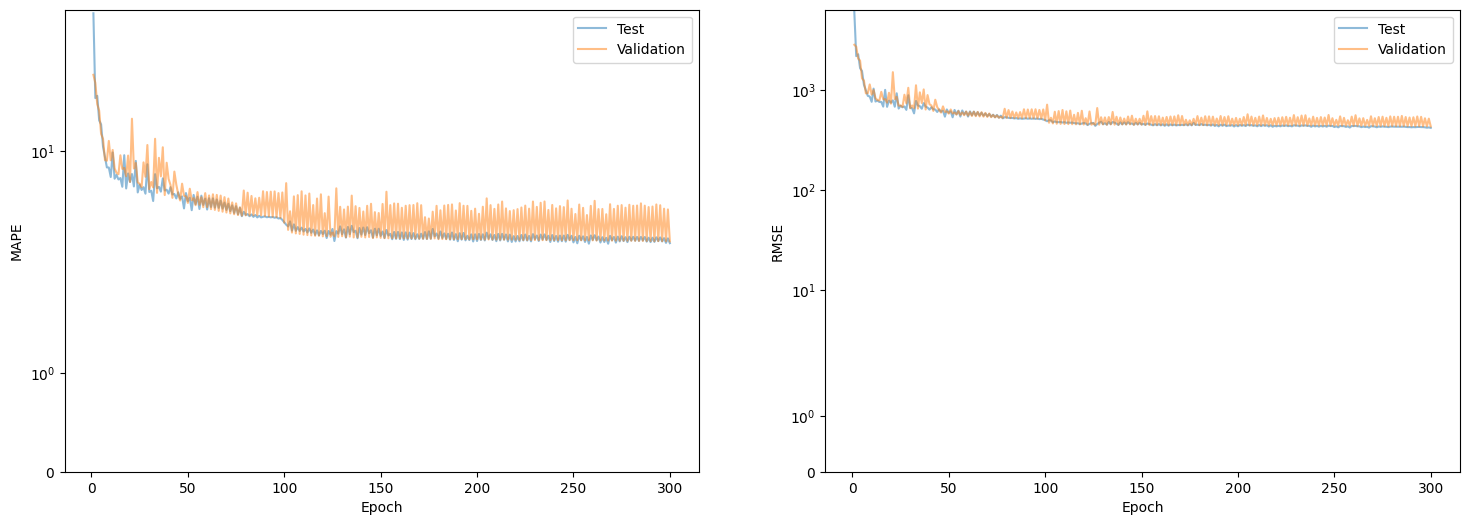

In [15]:
y_pred = model_mlp.predict(X_val)
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ' MAPE:', MAPE(y_val[:,i], y_pred[:,i]).numpy())
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ' R2:', r2_score(y_val[:,i], y_pred[:,i]))

mlp_history_df = pd.DataFrame(mlp_history.history)
mlp_history_df['epoch'] = (mlp_history_df.index+1).to_list()
mse_cols = [e for e in mlp_history_df.columns if 'mean_squared_error' in e]
mlp_history_df[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = mlp_history_df[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
metrics = ['loss', 'RMSE']

for i, ax in enumerate(axes):

    metric = metrics[i]
    label = metric.replace('loss', 'MAPE')

    sns.lineplot(mlp_history_df, x='epoch', y=metric, ax=ax, label='Test', alpha=0.5)
    sns.lineplot(mlp_history_df, x='epoch', y=f"val_{metric}", ax=ax, label='Validation', alpha=0.5)

    ax.set_ylim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    ax.set_yscale('symlog')
    
plt.show()
    


In [21]:
[e for e in dir(model_mlp) if 'import' in e]


[]

In [17]:
model_mlp.get_weights()


[array([[ 0.09828883,  0.4561752 , -0.88877726, ...,  0.03194866,
         -0.77178496,  0.09820748],
        [-0.05740175,  0.26379833, -0.24779633, ...,  0.16454117,
          0.10119695,  0.07668819],
        [ 0.03609703, -0.04802529,  0.02488377, ...,  0.06777071,
          0.32410434,  0.12785871],
        ...,
        [ 0.40326378,  0.24849525, -0.25578463, ..., -0.22538929,
         -0.37248126,  0.05357351],
        [-0.1262731 , -0.2601884 ,  0.26059407, ..., -0.0653815 ,
          0.16138645, -0.24705854],
        [-0.1658174 , -0.3164109 ,  0.44463563, ..., -0.15598598,
          0.02791666,  0.00510041]], dtype=float32),
 array([ 0.14582956, -0.30885383, -0.36119875,  0.02629993, -0.26279306,
        -0.45863366, -0.17320582, -0.20217651,  0.02927306,  0.00168055,
         0.18119818,  0.03080499, -0.13551308, -0.4027954 ,  0.21532962,
        -0.26604477, -0.00944372, -0.5329012 ,  0.40162894,  0.02077826,
         0.20259504,  0.16163856, -0.01977114, -0.22185712, -0.048

In [25]:
main_input = Input(shape=(X_train[0].shape[0],1), name="input")
previous_layer = main_input
previous_layer = Bidirectional(LSTM(64, return_sequences=True), name=f"BD_1")(previous_layer)
previous_layer = Bidirectional(LSTM(32), name=f"BD_2")(previous_layer)

previous_layer = Dense(32, name=f"relu_{1}", activation='relu')(previous_layer)
main_output = Dense(2, name=f"output")(previous_layer)

def scheduler(epoch, lr):
    return 0.001 if epoch % 2 == 1 else 0.01

model_lstm = Model(inputs=main_input, outputs=main_output, name="BD-LSTM")
model_lstm.compile(optimizer=Adam(
    learning_rate=.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    weight_decay=1e-4,
    clipnorm=None,
    clipvalue=None,
    global_clipnorm=None,
    use_ema=False,
    ema_momentum=0.99,
    ema_overwrite_frequency=None,
    name='Adam',
), loss=MeanAbsolutePercentageError(), metrics=[MSE])
lstm_history = model_lstm.fit(
    X_train, y_train, verbose=1, validation_data=(X_val, y_val), shuffle=False,
    epochs=1000, batch_size=2**10, 
    callbacks=[
        LearningRateScheduler(scheduler), 
        EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True), 
    ]
)

# LSTM(Hidden, activation='relu')
# batch_size=64, verbose=0, shuffle=False


Epoch 1/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 235s 2s/step - loss: 95.4269 - mean_squared_error: 67636112.0000 - val_loss: 54.5067 - val_mean_squared_error: 21846452.0000 - learning_rate: 0.0100
Epoch 2/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 291s 2s/step - loss: 53.3276 - mean_squared_error: 23162970.0000 - val_loss: 45.3679 - val_mean_squared_error: 15808465.0000 - learning_rate: 0.0010
Epoch 3/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - loss: 29.9342 - mean_squared_error: 10277247.0000 - val_loss: 12.3678 - val_mean_squared_error: 1777050.6250 - learning_rate: 0.0100
Epoch 4/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - loss: 13.8527 - mean_squared_error: 2227610.5000 - val_loss: 12.3269 - val_mean_squared_error: 1730719.0000 - learning_rate: 0.0010
Epoch 5/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 3585s 28s/step - loss: 13.5697 - mean_squared_error: 2062679.1250 - val_loss: 10.4394 - val_mean_squared_error: 1491674.3750 - learning_rate: 0.0100
Epoch 6/1000
131/131 ━━━━━━━━━━━━━━━━━━━━ 82s 62

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step  LR=0.01  
 H1: 1.8942682  
H24: 3.261359  
  
 H1: 2.3578866  
H24: 3.7653885  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  LR=0.001  
 H1: 2.2099416  
H24: 3.548185  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  0.0001 if epoch % 2 == 1 else 0.001  (Epoch 154/1000)  
 H1: 1.4781239  
H24: 3.2230973  

444/444 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step  0.001 if epoch % 2 == 1 else 0.01  weight_decay=1e-4  
 H1: 1.6845292  
H24: 5.536489  

 H1: 1.4077302  
H24: 5.5795336  

 H1: 1.2028637  
H24: 4.388582







418/418 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step
 H1: 1.2028637
H24: 4.388582


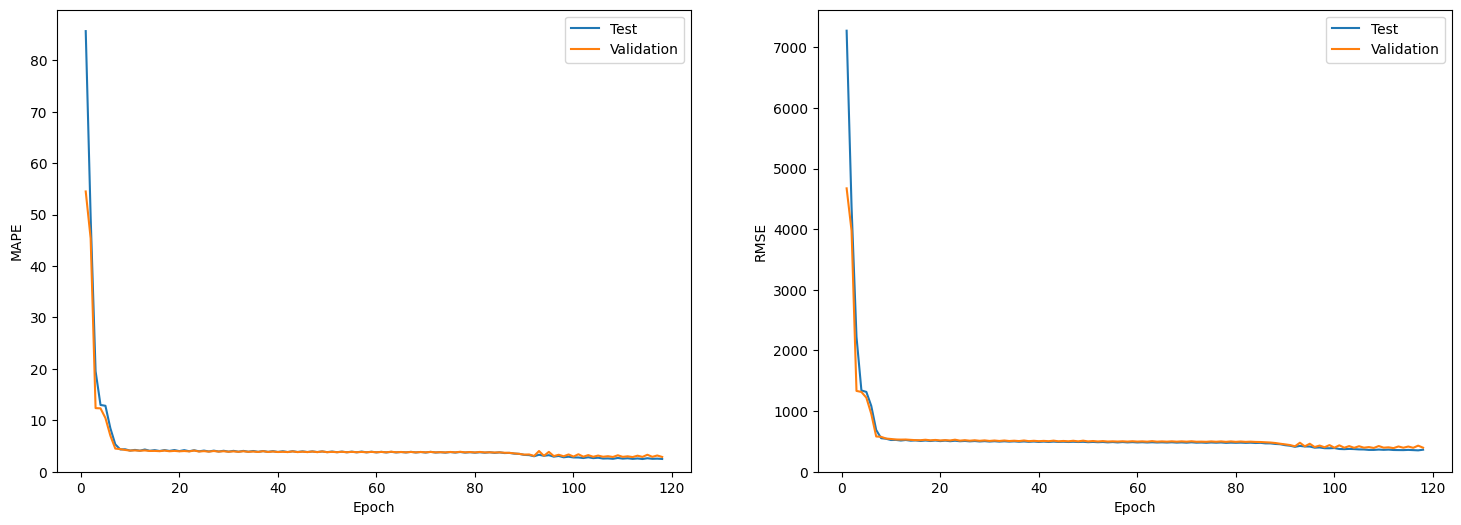

In [26]:
y_pred = model_lstm.predict(X_val)
for i in range(2):
    print(('H24' if i else 'H1'.rjust(3)) + ':', MAPE(y_val[:,i], y_pred[:,i]).numpy())

lstm_history_df = pd.DataFrame(lstm_history.history)
lstm_history_df['epoch'] = (lstm_history_df.index+1).to_list()
mse_cols = [e for e in lstm_history_df.columns if 'mean_squared_error' in e]
lstm_history_df[[e.replace('mean_squared_error', 'RMSE') for e in mse_cols]] = lstm_history_df[mse_cols].apply(lambda d: d.apply(lambda e: e**.5), axis=1)

fig, axes = plt.subplots(1, 2, figsize=(18,6))
metrics = ['loss', 'RMSE']

for i, ax in enumerate(axes):

    metric = metrics[i]
    label = metric.replace('loss', 'MAPE')

    sns.lineplot(lstm_history_df, x='epoch', y=metric, ax=ax, label='Test')
    sns.lineplot(lstm_history_df, x='epoch', y=f"val_{metric}", ax=ax, label='Validation')

    ax.set_ylim(0)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(label)
    
plt.show()
